## Purpose

In the previous Notebooks, we calculated some of the fundamental metrics for customer segmentation, as well as extra data that will help us understand customer purchasing habits. This notebook explores a combined view of both datasets, and aims to perform customer segmentation using standard sklearn algorithms.

In [90]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd  # For processing and IO

from sklearn.preprocessing import (
    Normalizer, StandardScaler
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

from matplotlib import pyplot as plt
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [34]:
# We initiate random seeds for algorithms
KM_RANDOM_SEED=42
PCA_RANDOM_SEED=7

### Data loading

We will now load all of the data we processed over the last two notebooks.

In [3]:
apps = pd.read_json(
    '../data/processed/apps_with_genresim.json'
)
apps['release_date__dt'] = pd.to_datetime(
    apps['release_date__date'], 
    format='%b %d, %Y',
    utc=True
)
display(apps.sample(5))
print(apps.shape)

users = pd.read_csv(
    '../data/raw/purchase_data.csv',
    parse_dates=['timestamp_purchased']
)
display(users.sample(5))
print(users.shape)

users_rf = pd.read_json(
    '../data/processed/simple_userRF.json'
)
display(users_rf.sample(5))
print(users_rf.shape)

,appid,name,release_date__date,genre_description,categories_description,short_description,about_the_game,genre_sim_NieR,release_date__dt
101,35070,Flora's Fruit Farm,"Oct 1, 2009",Casual,Single-player,None,Clementine Valley used to be the place to be! ...,0.000000,2009-10-01 00:00:00+00:00
73,202370,Scarygirl,"Apr 9, 2012",Action,"Partial Controller Support,Shared/Split Screen...",None,"In this side-scrolling action game, you play a...",0.333333,2012-04-09 00:00:00+00:00
57,34600,Order of War™,"Sep 17, 2009",Strategy,Single-player,None,"October 22, 2009 - Update <br>\t\t\t\t\t<a hre...",0.000000,2009-09-17 00:00:00+00:00
35,40100,Supreme Commander 2,"Mar 1, 2010",Strategy,"Multi-player,Single-player,Stats,Steam Achieve...","Includes 47 Steam achievements, leaderboards, ...","In Supreme Commander 2, players will experienc...",0.000000,2010-03-01 00:00:00+00:00
61,39190,Dungeon Siege,"Apr 5, 2011",RPG,Single-player,None,Dungeon Siege® combines the immersive elements...,0.333333,2011-04-05 00:00:00+00:00


(84, 9)


,userid,appid,timestamp_purchased
28643,7ccd4d0d78dcd2e8d0c38a566594d74cf3084b32e9330f...,39200,2015-08-22 12:32:00.554344+00:00
28594,81b91024642ef9ee21445de36907dd6d55c98d6f9f570d...,39200,2016-12-10 16:03:07.554344+00:00
79461,4dd56c798dd5cd0e05f9bb3f5af894cd6f581a78743b9e...,319630,2015-11-26 07:23:37.554344+00:00
152233,c91fd48c410187fd630b05453c7e942d43afbe7a3166a9...,39140,2016-11-24 18:10:07.554344+00:00
61318,d4c61c1f3802d64c6dad1e8b33c9186bcb2e01981d7952...,337000,2016-10-18 17:34:18.554344+00:00


(180995, 3)


,userid,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016
26624,2c43b67070b6a3bd2a46fbed5ab15b67ee8435c4533b31...,1232,1,0,0,0
123937,cecd2ec586d4fc26fe89bcbf771e17f844b23304355bdf...,446,0,0,1,0
96532,a1334e2dbf39d9e6cc61fdc5f8b37aefcf48ffc1697af4...,157,0,0,0,2
50579,53fae1457026550f9252a9b8dff850f27e29101715fbf6...,653,0,0,1,0
116556,c26f445f649cee0586e4400c10717a39371a2403f68050...,420,0,0,0,1


(153206, 6)


Let's merge the apps and user data, so we can increase our knowledge of user behaviour based on game genres.

In [4]:
users_apps = users.merge(
    apps,
    on='appid',
)
display(users_apps.sample(5))
print(users_apps.shape)

,userid,appid,timestamp_purchased,name,release_date__date,genre_description,categories_description,short_description,about_the_game,genre_sim_NieR,release_date__dt
129974,35f3866a8d31513986b60cbc9eb049d1e5042573fb8faa...,8190,2016-02-17 03:14:09.554344+00:00,Just Cause 2,"Mar 23, 2010","Action,Adventure","Full controller support,Single-player,Steam Ac...",Dive into an adrenaline-fuelled free-roaming a...,Dive into an adrenaline-fuelled free-roaming a...,0.250000,2010-03-23 00:00:00+00:00
116698,a6fd510c5fe7622733e47376ed3ceb0f1fcb31d9c32379...,39160,2015-04-03 19:12:53.554344+00:00,Dungeon Siege III,"Jun 20, 2011","Action,RPG","Co-op,Multi-player,Single-player,Steam Achieve...",Fight hordes of dangerous creatures in a mysti...,For centuries legionnaires have protected the ...,0.666667,2011-06-20 00:00:00+00:00
48180,b01810f920e9c2d2e2ca25e815a55208ccf16b86e3684a...,337000,2016-08-28 20:24:50.554344+00:00,Deus Ex: Mankind Divided™,"Aug 23, 2016","Action,RPG","Full controller support,Single-player,Steam Ac...","Now an experienced covert operative, Adam Jens...","<img src=""https://steamcdn-a.akamaihd.net/stea...",0.666667,2016-08-23 00:00:00+00:00
81653,fc77951e952d32d25b5db0daccbb3365b9fc46d035654b...,203160,2014-08-06 08:27:55.554344+00:00,Tomb Raider,"Mar 4, 2013","Action,Adventure","Full controller support,Multi-player,Single-pl...",Tomb Raider explores the intense origin story ...,"<img src=""https://steamcdn-a.akamaihd.net/stea...",0.250000,2013-03-04 00:00:00+00:00
114007,e0e79e2b47526d96cd5ec6eb2fcb3981002254ad83c7a7...,39150,2013-12-09 09:48:22.554344+00:00,FINAL FANTASY VIII,"Dec 5, 2013",RPG,"Partial Controller Support,Single-player,Steam...",None,<strong>It is a time of war.</strong> Galbadia...,0.333333,2013-12-05 00:00:00+00:00


(133525, 11)


In [5]:
users_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133525 entries, 0 to 133524
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   userid                  133525 non-null  object             
 1   appid                   133525 non-null  int64              
 2   timestamp_purchased     133525 non-null  datetime64[ns, UTC]
 3   name                    133525 non-null  object             
 4   release_date__date      133525 non-null  object             
 5   genre_description       133525 non-null  object             
 6   categories_description  133525 non-null  object             
 7   short_description       93972 non-null   object             
 8   about_the_game          133525 non-null  object             
 9   genre_sim_NieR          133525 non-null  float64            
 10  release_date__dt        133525 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2),

Given we merged app information to the user purchases, the reduction in the number of data points (from 180,995 to 133,525) means that there are apps on the `users` that were not present in the `apps` dataframe.

Before we assign the RF values to each user, we should first simplify the genre similarity data, so that it reflects whether or not, on average, a given user prefers games like NieR:Automata$^{TM}$.

In [6]:
users_apps = users_apps.groupby(
    'userid',
    as_index=False
).aggregate(
    {
        'genre_sim_NieR': np.nanmean
    }
)
display(users_apps)

,userid,genre_sim_NieR
0,00002eaf0b53c394391f96a5cae5023ef8ae704797880b...,0.666667
1,00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe2...,0.250000
2,000364b1cefaf76b3abf76080595936a32de847e908ee7...,0.666667
3,00048a2093a1786989d15a4855ba1c3511c02e4c921094...,0.250000
4,0004f2043ce240448a1f508cee1413730a207f8dabdd2c...,0.666667
...,...,...
114228,fffd9ad8ce7c05dae1e41aa5a3c7e440dd194c14bf8e7a...,0.333333
114229,fffe5f488a6795e0cf201a22f3e14fd9e5edc238b8e7cc...,0.250000
114230,ffff0366ce6fca05e189be83e199c5efd05d1a72f628ba...,0.250000
114231,ffff81c2a0938752d35139f9990671df0b26c4d70b4c78...,0.250000


We can then assign to each user their RF metrics.

In [7]:
full_data = users_apps.merge(
    users_rf,
    on='userid'
)
display(full_data.sample(5))
print(full_data.shape)

,userid,genre_sim_NieR,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016
23408,3435a0cceb0aca82509d1e36147ea71ba881fcf9dafba6...,0.250000,9,0,0,0,1
30126,42f54d7b050c0824d8786770aefd0e5506eb83dae045d1...,0.250000,808,0,1,0,0
63778,8ebcc2788fba406eefb1cba1ea0e7cd9116b69bc906968...,0.666667,1063,0,1,0,0
57220,7fc6c03091dd28ed0c532ce3e410695414efce43ba78aa...,0.666667,188,0,0,0,1
43778,619ad2636f4279b084d889fc165731189493a227c52f69...,0.333333,1066,0,1,0,0


(114233, 7)


Let's visualise our data before continuing.

<AxesSubplot:ylabel='Frequency'>

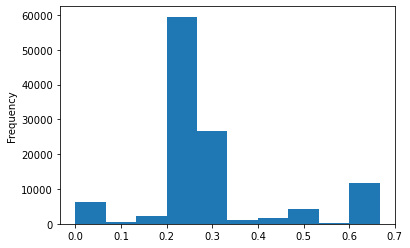

In [8]:
full_data['genre_sim_NieR'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

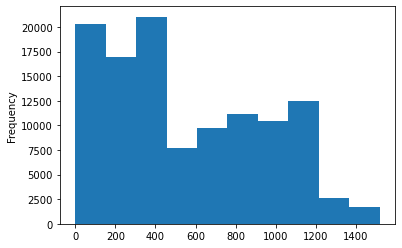

In [9]:
full_data['user_recency'].plot(kind='hist')

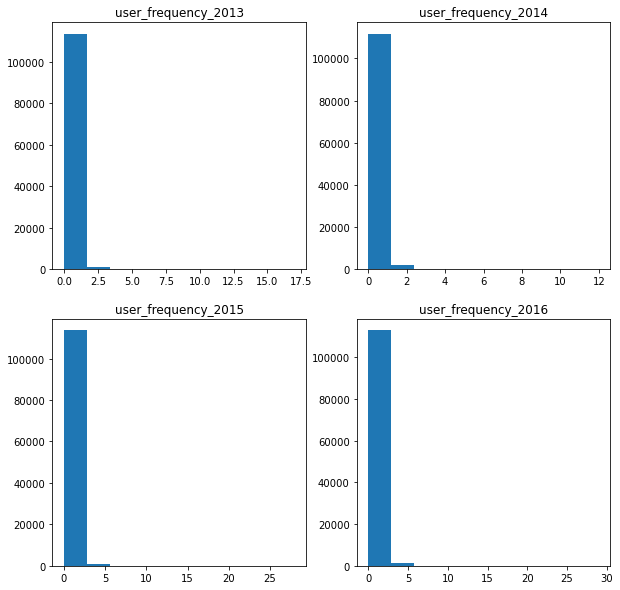

In [10]:
cols = full_data.filter(regex='user_frequency_').columns.to_list()

fig, ax = plt.subplots(
    2,2, figsize=(10,10)
)

for col,i in zip(cols, np.ndenumerate(ax)):
    ax[i[0]].hist(full_data[col])
    ax[i[0]].set_title(col)

Since we are going to be clustering data using K-Means (as it is the simplest algorithm we can use), we need to correctly pre-process the data. It needs to be normally distributed and normalised.

### Preprocessing: Normalising and Standardisation

A number of columns have a very skewed distribution, and as such, they need to be converted so that they are as close to a standard normal distribution as possible. The most common way to do this is to apply some transformation to the data, such as log or square root or cube root. After that, we can try a Box-Cox transform.

Let's write a function that goes through a standard set of standardisations.

In [91]:
def try_many_standardisations(column: pd.Series) -> None:
    """
    Plot a number of standardisation and transformations.
    """
    fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(10, 2))
    
    # Plot the original
    column.plot(kind='hist', ax=ax[0], bins=15)
    ax[0].set_title('Original')
    
    # Plot the normalised array
    pd.Series(Normalizer().fit_transform(
        column.values.reshape(-1, 1)
    ).reshape(-1, )).plot(kind='hist', ax=ax[1], bins=15)
    ax[1].set_title('Normalised')
    
    # Plot the logarithmic transformed data
    np.log(
        column[column > 0]
    ).plot(kind='hist', ax=ax[2], bins=15)
    ax[2].set_title('Log (0s removed)')
    
    # Plot the square root transformed data
    np.sqrt(column).plot(kind='hist', ax=ax[3], bins=15)
    ax[3].set_title('Square Root')
    
    # Plot the cube root transformed data
    (column ** (1/3)).plot(kind='hist', ax=ax[4], bins=15)
    ax[4].set_title('Cube Root')
    
    plt.tight_layout()

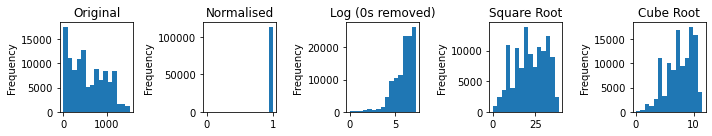

In [12]:
# Let's try it!
try_many_standardisations(full_data['user_recency'])

Looking at the transformed data, square root transformation more closely makes our data look like a normal distribution. It's not, by any means, a perfect Gaussian, but it'll do for now.

The genre similarity column is already roughly normally distributed; it just needs to be transformed.

The frequency data is heavily right skewed, as seen below.

In [15]:
full_data.filter(regex='user_frequency').agg('skew')

user_frequency_2013    4.913194
user_frequency_2014    2.541119
user_frequency_2015    4.711436
user_frequency_2016    4.185790
dtype: float64

What we can do with the frequency data is remove every point not equal to 1 (since most of our clients bought one game over the 4 years), but this would remove the influence of having clients that purchase multiple games multiple times per year (which we would consider high value clients).

With this, let's transform the relevant columns (in our case, we will impose a square root transformation on the `user_recency` column), and stanardise every other relevant column.

In [22]:
full_data['user_recency_sr'] = np.sqrt(full_data['user_recency'])

In [24]:
scaler = StandardScaler()

full_data_standardised = full_data.copy(deep=True)

cols_to_std = [
    'genre_sim_NieR',
    'user_recency_sr',
    'user_frequency_2013',
    'user_frequency_2014', 
    'user_frequency_2015', 
    'user_frequency_2016',
]

for col in cols_to_std:
    scaler = StandardScaler()
    full_data_standardised[
        f'{col}_std'
    ] = scaler.fit_transform(
        full_data_standardised[col].values.reshape(-1, 1)
    )

display(full_data_standardised.head())

,userid,genre_sim_NieR,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016,user_recency_sr,genre_sim_NieR_std,user_recency_sr_std,user_frequency_2013_std,user_frequency_2014_std,user_frequency_2015_std,user_frequency_2016_std
0,00002eaf0b53c394391f96a5cae5023ef8ae704797880b...,0.666667,176,0,0,0,1,13.266499,2.368959,-0.943674,-0.319101,-0.550962,-0.523706,0.694216
1,00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe2...,0.250000,1455,1,0,0,0,38.144462,-0.403591,1.793497,2.391075,-0.550962,-0.523706,-0.741147
2,000364b1cefaf76b3abf76080595936a32de847e908ee7...,0.666667,185,0,0,0,1,13.601471,2.368959,-0.906819,-0.319101,-0.550962,-0.523706,0.694216
3,00048a2093a1786989d15a4855ba1c3511c02e4c921094...,0.250000,378,0,0,0,1,19.442222,-0.403591,-0.264197,-0.319101,-0.550962,-0.523706,0.694216
4,0004f2043ce240448a1f508cee1413730a207f8dabdd2c...,0.666667,177,0,0,0,1,13.304135,2.368959,-0.939533,-0.319101,-0.550962,-0.523706,0.694216


Alright, let's try clustering!

We will first simplify the dataframe, so that we feed only the data we want to feed.

In [25]:
for_kmeans = full_data_standardised.set_index(
    'userid' # we no longer need the userid column, 
).filter(
    regex='_std' # To keep every standardised column
)
display(for_kmeans.head())

,genre_sim_NieR_std,user_recency_sr_std,user_frequency_2013_std,user_frequency_2014_std,user_frequency_2015_std,user_frequency_2016_std
userid,,,,,,
00002eaf0b53c394391f96a5cae5023ef8ae704797880bb97b1a78eb0c6eb05a,2.368959,-0.943674,-0.319101,-0.550962,-0.523706,0.694216
00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe280dd1adb8b143e3ff1,-0.403591,1.793497,2.391075,-0.550962,-0.523706,-0.741147
000364b1cefaf76b3abf76080595936a32de847e908ee70cf0ac25cff96b6fe0,2.368959,-0.906819,-0.319101,-0.550962,-0.523706,0.694216
00048a2093a1786989d15a4855ba1c3511c02e4c9210940b1a4fa83b0831c967,-0.403591,-0.264197,-0.319101,-0.550962,-0.523706,0.694216
0004f2043ce240448a1f508cee1413730a207f8dabdd2c10812ca4e32169f01c,2.368959,-0.939533,-0.319101,-0.550962,-0.523706,0.694216


### Clustering

It is now time for us to experiment with K-Means clustering!

K-Means has a number of hyperparameters, but we are looking to change 1: `n_clusters`. This will determine the number of customer segments we create. For completion, however, we should look into the number of ideal clusters in our data using the `.inertia_` parameter.

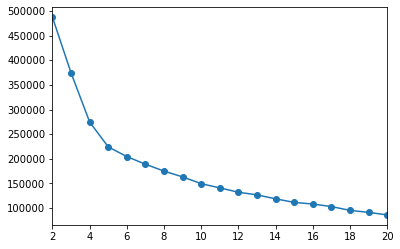

In [32]:
SSEs = []
for clust in range(2, 21):  # from 2 to 20 clusters

    kmeans = KMeans(n_clusters=clust)
    kmeans.fit(for_kmeans)
    
    SSEs.append(kmeans.inertia_)

plt.plot(range(2, 21), SSEs, marker='o')
plt.xlim([2, 20])
plt.show()

So it appears that 3-5 clusters are a good starting point. 

Ideally, we want to plot and analyse the results of our clustering. We can plot the clusters using PCA. We will create a set of helper functions to create clusters based on a desired number of clusters, and that plots the clusters.

In [65]:
def perform_kmeans(df: pd.DataFrame, n_clusters: int) -> np.array:
    """
    Small helper function to perform KMeans with a set number of
    clusters.
    
    Returns the clusters from KMeans.
    """
    # We create the clusters
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=KM_RANDOM_SEED
    )
    kmeans.fit(df)

    return kmeans.labels_
    

def plot_kmeans(df: pd.DataFrame, ax = None):
    """
    Plots the clusters from k-means (data is reduced to 
    2 dimensions using PCA).
    """
    # We decompose the data
    decomp = PCA(
        2, 
        random_state=PCA_RANDOM_SEED
    ).fit_transform(df)
    
    unique_labels = np.unique(df['cluster'])
    
    if not ax:
        _, ax = plt.subplots()
    for lbl in unique_labels:
        ax.scatter(
            decomp[df['cluster'] == lbl, 0], 
            decomp[df['cluster'] == lbl, 1],
            s=2.5,
            label = f'Cluster {lbl+1}'
        )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

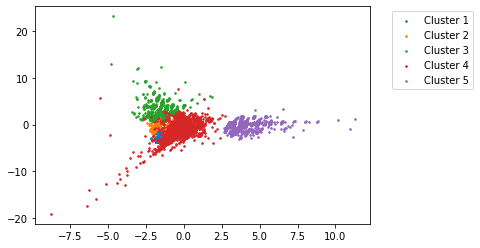

In [70]:
for_kmeans['cluster'] = perform_kmeans(for_kmeans, 5)
plot_kmeans(for_kmeans)

Ideally we should find a more colorblind friendly color palette and even use different markers for the different clusters.

---

We now have a way of clustering data and plotting it! Now we just need to decide on the number of clusters and finding a way to characterise each of them. For the same of simplicity, let's use 10 clusters, which will create 10 customer segments.

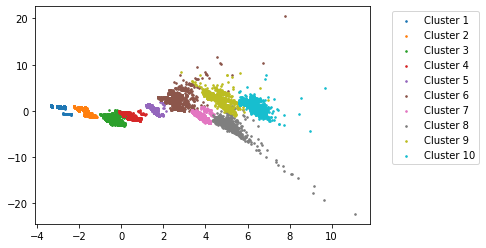

In [72]:
for_kmeans['cluster'] = perform_kmeans(for_kmeans, 10)
plot_kmeans(for_kmeans)

One way we can check the characteristics of our clusters is to aggregate the resulting dataframe by cluster, and then taking the average of each quantity.

In [85]:
def analyse_clusters(data: pd.DataFrame) -> pd.DataFrame:
    """
    Analyses the clustered data. Returns agregated dataframe.
    """
    # Averages for each column
    aggr = data.groupby('cluster').mean()
    
    # And the number of members in each cohort
    aggr = pd.concat(
        [
            aggr, 
            data.groupby('cluster').size()
        ], 
        axis=1
    ).rename(columns={0: 'cohort_size'})
    
    return aggr

In [87]:
full_data['cluster'] = perform_kmeans(for_kmeans, 10)
analyse_clusters(full_data.drop('user_recency_sr', axis=1))

,genre_sim_NieR,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016,cohort_size
cluster,,,,,,,
0,0.267576,957.226539,0.000000,1.000000,0.021330,0.010622,23347
1,0.620660,708.469396,0.002866,0.363767,0.695599,0.038485,4885
2,0.262237,316.471103,0.001063,0.020344,0.005972,1.064980,19760
3,0.273845,1165.194075,1.105208,0.078819,0.053915,0.048060,11444
4,0.253595,566.819662,0.000000,0.025628,1.000000,0.053568,21188
5,0.638082,165.534499,0.009009,0.039428,0.035718,1.083837,9435
6,0.310592,485.089895,0.041463,0.158188,2.400348,0.321254,2870
7,0.252438,82.414964,0.016235,0.032357,0.057391,1.111603,17616
8,0.304012,794.990681,0.085494,2.333063,0.177066,0.191248,2468


Ignoring the `user_recency_sr` column, we can see some patterns appearing in the clusters. For example, cluster 7 contains users who have more recently bought games fromour company, but have a lower preference to games like NieR. Cluster 0 has a significant number of users who were very active in 2014, which we might potentially call disengaged or churned customers.

If we look into the genre similarity, customers in clusters 1 and 5 seem to be more likely to purchase NieR compared to others, with customers in cluster 5 having been active more recently.

If we split the number of segments further, more of these distinctions will surface. Let's look at 20.

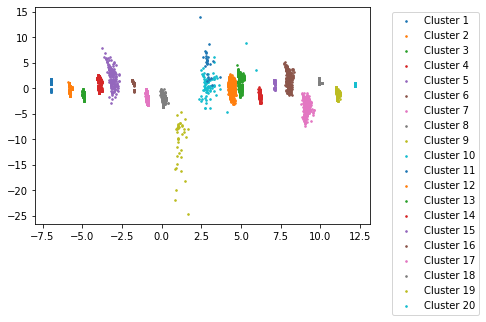

In [88]:
for_kmeans['cluster'] = perform_kmeans(for_kmeans, 20)
plot_kmeans(for_kmeans)

In [89]:
full_data['cluster'] = perform_kmeans(for_kmeans, 20)
analyse_clusters(full_data.drop('user_recency_sr', axis=1))

,genre_sim_NieR,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016,cohort_size
cluster,,,,,,,
0,0.638038,165.527230,0.009112,0.040051,0.035813,1.084128,9438
1,0.269782,579.529187,0.000000,0.000000,1.000000,0.000000,18330
2,0.272346,1176.009524,1.000000,0.064190,0.046381,0.037048,10500
3,0.273714,316.144605,0.001010,0.019784,0.000000,1.060522,18803
4,0.000000,982.372380,0.000000,1.000000,0.000000,0.000000,1622
5,0.288700,229.784846,0.016370,0.050514,1.001871,1.155285,2138
6,0.276673,78.856209,0.016006,0.030079,0.000000,1.110778,14994
7,0.287701,961.032883,0.000000,1.000000,0.000000,0.011683,21227
8,0.599454,582.010463,0.004484,0.070553,1.012855,0.056203,3345


In the clustering above, we can see that customers in cluster 12 do not care for games like NieR, so we can more safely assume they won't be purchasing the game. Ideally, we would choose to ignore customers based on the business requirement or philosophy, but this is a relatively small cluster (1,292), we could safely ignore it. Another way to see this is that if we want to advertise a game to our customers that is the opposite of NieR, we should start with cluster 12!

The issue with having a large number of segments is that we must analyse and label them. This can potentially be a very time consuming exercise, so it might be better to either get some guidance based on stakeholder requirements, or stick to a manageable number of clusters.

---

Given the results from applying KMeans on our data, with 10 clusters, we could reasonably suggest that users in clusters 1 and 5 are more likely to buy NieR, based on their past shopping preferences, as well as their relative recency. We could also say that customers in cluster 7 are also likely to buy NieR, based on their recency.

### Next steps

Before we wrap up in this Notebook, there are 2 extra columns we can look into. We could look into how long before/after release our customers purchase games, and we could look into whether game descriptions can help us better understand our customers.

With the advent of Steam and other such platforms, games are often released in earlier versions **before** their official release. We can look into our customer base to find out if they are more likely to purchase a game before release, which then gives us further confidence that they will likely buy NieR.

Gae descriptions often give us a more extensive description of the game itself, and we might be able to use some keywords or phrases to further distinguish games that might share similr genres.

We will tackle both of these in the next few Notebooks.